# Figure 3b

In [1]:
import numpy as np
import sempler
import sempler.generators

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec

import pickle
import os

import ut_lvcm.utils as utils
import ut_lvcm.metrics

/home/juan/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:1008: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/juan/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1858: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)


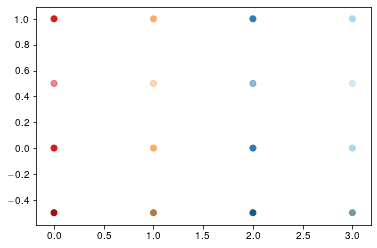

In [2]:
# Set tex formatting for plots
from matplotlib import rc
#rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
# Colors
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ['#d7191c', '#fdae61', '#2c7bb6', '#abd9e9']
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

In [3]:
def read_result(filename):
    if os.path.getsize(filename) > 0:
        with open(filename, "rb") as f:
            return pickle.load(f)

In [4]:
def initial_metrics(truth, initial_graphs):
    # Also compute the t1/t2 metrics for the initial graphs
    (true_model, true_I) = truth
    true_imec = utils.imec(true_model.A, true_I)
    #print("len(true_imec) =", len(true_imec))
    t1 = ut_lvcm.metrics.type_1_structc(initial_graphs, true_imec)
    t2 = ut_lvcm.metrics.type_2_structc(initial_graphs, true_imec)
    return t1,t2

In [5]:
def extract_metrics(files, runs=50):
    # Extract the t1/t2 metrics
    Ns = np.array([100,500,1000,10000])
    t1 = np.zeros((len(Ns),runs))
    t2 = np.zeros_like(t1)
    t1_init = np.zeros_like(t1)
    t2_init = np.zeros_like(t1)
    reprs = np.zeros_like(t1)

    # --------------------------------------------------
    elapseds = []
    for file in files:
        results = read_result(file)
        n = results[0].n
        j = np.where(Ns == n)[0][0]
        print("  ",n,j)
        for k, (true_model, true_I), run_result in results[2]:        
            (estimated_model, estimated_I, _), history, metrics, elapsed = run_result
            elapseds.append(elapsed)            
            metrics=dict(metrics)
            t1[j,k] = metrics[ut_lvcm.metrics.type_1_struct]
            t2[j,k] = metrics[ut_lvcm.metrics.type_2_struct]            
            t1_init[j,k], t2_init[j,k] = initial_metrics((true_model, true_I), history['initial_graphs'])
            true_icpdag = utils.dag_to_icpdag(true_model.A, true_I)
            reprs[j,k] = utils.is_consistent_extension(estimated_model.A, true_icpdag)

    print("Average run: %0.2f seconds" % np.mean(elapseds))
    
    # Check: The metric for the initial point of each graph is the same for all runs/sample sizes
    for (t1_init_graph,t2_init_graph) in zip(t1_init, t2_init):
        assert len(np.unique(t1_init_graph)) == 1
        assert len(np.unique(t2_init_graph)) == 1
    t1_init = t1_init[0,0]
    t2_init = t2_init[0,0]

    print("Done.")
    return t1,t2,t1_init,t2_init

In [6]:
def plot_roc(results_ch, results_rd, filename=None, Ns = np.array([100,500,1000,10000])):
    w = 2.5
    plt.figure(figsize=(3*w,w*0.95), dpi=100)
    gs = gridspec.GridSpec(1, 3, wspace=0.07, hspace=0)

    # Settings
    lim = [0,1]#[-0.02,1.02]
    markers = {100:'D', 500: 'o', 1000:'X', 10000:'.'}
    c = dict(zip([100,500,1000,10000], colors))
    cb = dict(zip([100,500,1000,10000], colorsb))
    xticks = [0, 0.25, 0.5, 0.75, 1]
    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]

    def plot(ax,results):
        for j,n in enumerate(Ns):
            t1,t2,t1_init,t2_init = results
            x, y = t1[j,:].mean(), 1-t2[j,:].mean()
            x_init, y_init = t1_init, 1-t2_init
            ax.plot(x,y, label="n=%d" % n,
                    marker=markers[n],
                    markerfacecolor=c[n],
                    markeredgecolor=cb[n],
                    markersize=8,
                    zorder=10 + n,
                    clip_on=False)
            ax.scatter(x_init, y_init, color='gray', marker='+', clip_on=False, zorder=10, s=60)
            ax.plot([x_init, x], [y_init, y], zorder=-1, linestyle=":", color='gray')
            ax.set_ylim(lim)
            ax.set_xlim(lim)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks)
            ax.set_xlabel("avg. FDP")


    # --------------------------------------------------
    # Plot chain graph
    plt.subplot(gs[0])
    ax = plt.gca()
    plot(ax, results_ch)
    ax.set_ylabel("avg. TDP")
    ax.set_title("Chain graph")

    # --------------------------------------------------
    # Plot random graph 1
    plt.subplot(gs[1])
    ax = plt.gca()
    plot(ax, results_rd)
    ax.set_yticklabels([])
    ax.set_title("Random graph")

    # Legend
    ax.legend(loc='lower right')
    sample_size_entries = [Line2D([0], [0],
                                  linestyle='None',
                                  marker=markers[n],
                                  markerfacecolor=c[n],
                                  markeredgecolor=cb[n]) for n in markers.keys()]
    sample_size_str = ["n = %d" % n for n in markers.keys()]
    initial_point_entry = [Line2D([0], [0], linestyle='None', marker='+', color='gray')]
    ax.legend(sample_size_entries + initial_point_entry, sample_size_str + ["MEC + rand. edges"], prop={'size':8}, loc='lower right', ncol=1)

    if filename is not None:
        plt.savefig("figures/" + filename, bbox_inches='tight')

## Figure 3b

In [7]:
files_baseline_3_rd_hs = [
"baseline_experiments/results_1688832745__seed:42_tag:fb3_disc:15_runs:50_no_edges:20_G:1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_init:4_np:0_fh:None_n:100/compiled_results.pickle",
"baseline_experiments/results_1688832745__seed:42_tag:fb3_disc:15_runs:50_no_edges:20_G:1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_init:4_np:0_fh:None_n:500/compiled_results.pickle",
"baseline_experiments/results_1688832748__seed:42_tag:fb3_disc:15_runs:50_no_edges:20_G:1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_init:4_np:0_fh:None_n:1000/compiled_results.pickle",
"baseline_experiments/results_1688832751__seed:42_tag:fb3_disc:15_runs:50_no_edges:20_G:1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_init:4_np:0_fh:None_n:10000/compiled_results.pickle",
]

# Chain graph


files_baseline_3_ch_hs = [
"baseline_experiments/results_1688832746__seed:42_tag:fb3_disc:15_runs:50_no_edges:20_G:-1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_init:4_np:0_fh:None_n:100/compiled_results.pickle",
"baseline_experiments/results_1688832747__seed:42_tag:fb3_disc:15_runs:50_no_edges:20_G:-1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_init:4_np:0_fh:None_n:500/compiled_results.pickle",
"baseline_experiments/results_1688832748__seed:42_tag:fb3_disc:15_runs:50_no_edges:20_G:-1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_init:4_np:0_fh:None_n:1000/compiled_results.pickle",
"baseline_experiments/results_1688832750__seed:42_tag:fb3_disc:15_runs:50_no_edges:20_G:-1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_init:4_np:0_fh:None_n:10000/compiled_results.pickle",
]



In [8]:
results_rd = extract_metrics(files_baseline_3_rd_hs)
results_ch = extract_metrics(files_baseline_3_ch_hs)

   100 0
   500 1
   1000 2
   10000 3
Average run: 8801.44 seconds
Done.
   100 0
   500 1
   1000 2
   10000 3
Average run: 11083.49 seconds
Done.


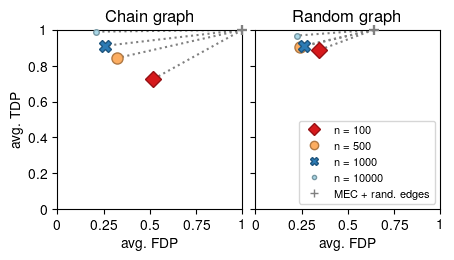

In [9]:
plot_roc(results_ch, results_rd, filename="figure_baseline_3.pdf")